# Simulation of Empirical Results

In [9]:
import pandas as pd
import numpy as np
from numpy.linalg import cholesky
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import BSpline, splrep, splev
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_openml
import urllib.request
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import skfda
from skfda.datasets import fetch_tecator, fetch_growth
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from matplotlib.lines import Line2D
from copy import deepcopy
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

## Simulation Study

In [2]:
# we set R = 1 to focus only on the complexity of the relationship between 
# a function and the response variable.
np.random.seed(2026)
torch.manual_seed(2026)
n_iterations = 100
# time grid 
m = 200
t = np.linspace(0, 1, m)
dt = t[1] - t[0]

# Covariance Matérn (ν = 5/2)
def matern52_cov(t, rho=0.5, sigma=1.0):
    T1, T2 = np.meshgrid(t, t)
    r = np.abs(T1 - T2)
    sqrt5_r = np.sqrt(5) * r / rho
    return sigma**2 * (1 + sqrt5_r + 5*r**2/(3*rho**2)) * np.exp(-sqrt5_r)


In [3]:
# Simulation of function Xi(t)

def simulate_functions(n, t):
    cov = matern52_cov(t)
    L = cholesky(cov + 1e-6*np.eye(len(t)))
    Z = np.random.randn(n, len(t))
    return Z @ L.T


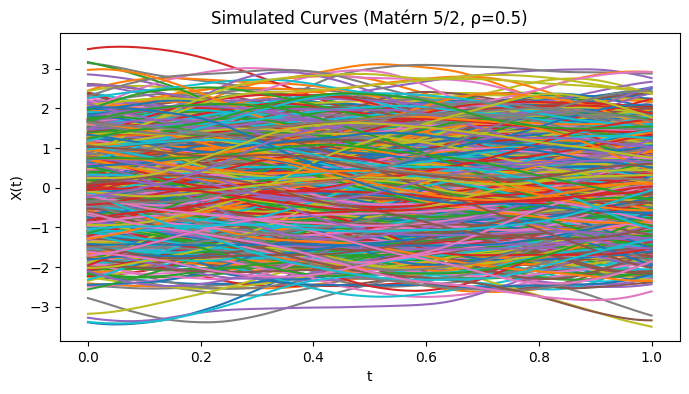

In [5]:
# visualisation of simulated curves of predictors

# Parameters
n_sim = 1500
m = 200
t = np.linspace(0, 1, m)

# Simulation
K = matern52_cov(t)
L = np.linalg.cholesky(K + 1e-8 * np.eye(m))
curves = np.random.standard_normal((n_sim, m)) @ L.T

# Plot
plt.figure(figsize=(8, 4))
for i in range(n_sim):
    plt.plot(t, curves[i, :])
plt.title("Simulated Curves (Matérn 5/2, ρ=0.5)")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.savefig('simulated_curves.png', dpi=300, bbox_inches='tight')
plt.show()

##### y is a continuous response

In [6]:
# Scenarios of true relation between Y ansd Xi(t) with continuous response and a single predictor function.

def scenario_linear(X, snr=2.0):
    beta = 5 * np.sin(2*np.pi*t)
    signal = (X @ beta) * dt
    signal_var = np.var(signal)
    noise_var = signal_var / snr
    return signal + np.random.randn(len(X)) * np.sqrt(noise_var)

def scenario_cam(X):
    return np.sum(X**2, axis=1) * dt + np.random.randn(len(X))

def scenario_single_index(X):
    beta = 5 * np.sin(2*np.pi*t)
    z = (X @ beta) * dt
    return z**2 + np.random.randn(len(X))

def scenario_multiple_index(X):
    beta1 = 5 * np.sin(2*np.pi*t)
    beta2 = 5 * np.sin(3*np.pi*t)
    z1 = (X @ beta1) * dt
    z2 = (X @ beta2) * dt
    return z1**2 + z2**2 + np.random.randn(len(X))

# Double integral of beta1(t)beta2(s)X(t)X(s) = (Intégrale beta1*X) * (Intégrale beta2*X)
def scenario_quadratic(X):
    beta1 = 5 * np.sin(3 * np.pi * t)
    beta2 = 5 * np.sin(np.pi * t)
    
    # Partie linéaire
    lin = (X @ beta1) * dt
    
    # Partie quadratique : double intégrale
    # ∬ β₁(t)β₂(s) X(t)X(s) ds dt
    # = ∫ β₁(t)X(t) [∫ β₂(s)X(s)ds] dt
    # = [∫ β₁(t)X(t)dt] × [∫ β₂(s)X(s)ds]
    quad = ((X @ beta1) * dt) * ((X @ beta2) * dt)
    
    return lin + quad + np.random.randn(len(X))

def scenario_complex_quadratic(X):
    # Terme 1: ∫ X(t)² dt
    term1 = (X**2 @ np.ones(m)) * dt
    
    # Terme 2: ∬ (X(t)X(s))² ds dt
    # Pour chaque échantillon i, calculer ∬ Xᵢ(t)²Xᵢ(s)² ds dt
    # = [∫ Xᵢ(t)² dt] × [∫ Xᵢ(s)² ds] = term1²
    term2 = term1**2
    
    return term1 + term2 + np.random.randn(len(X))

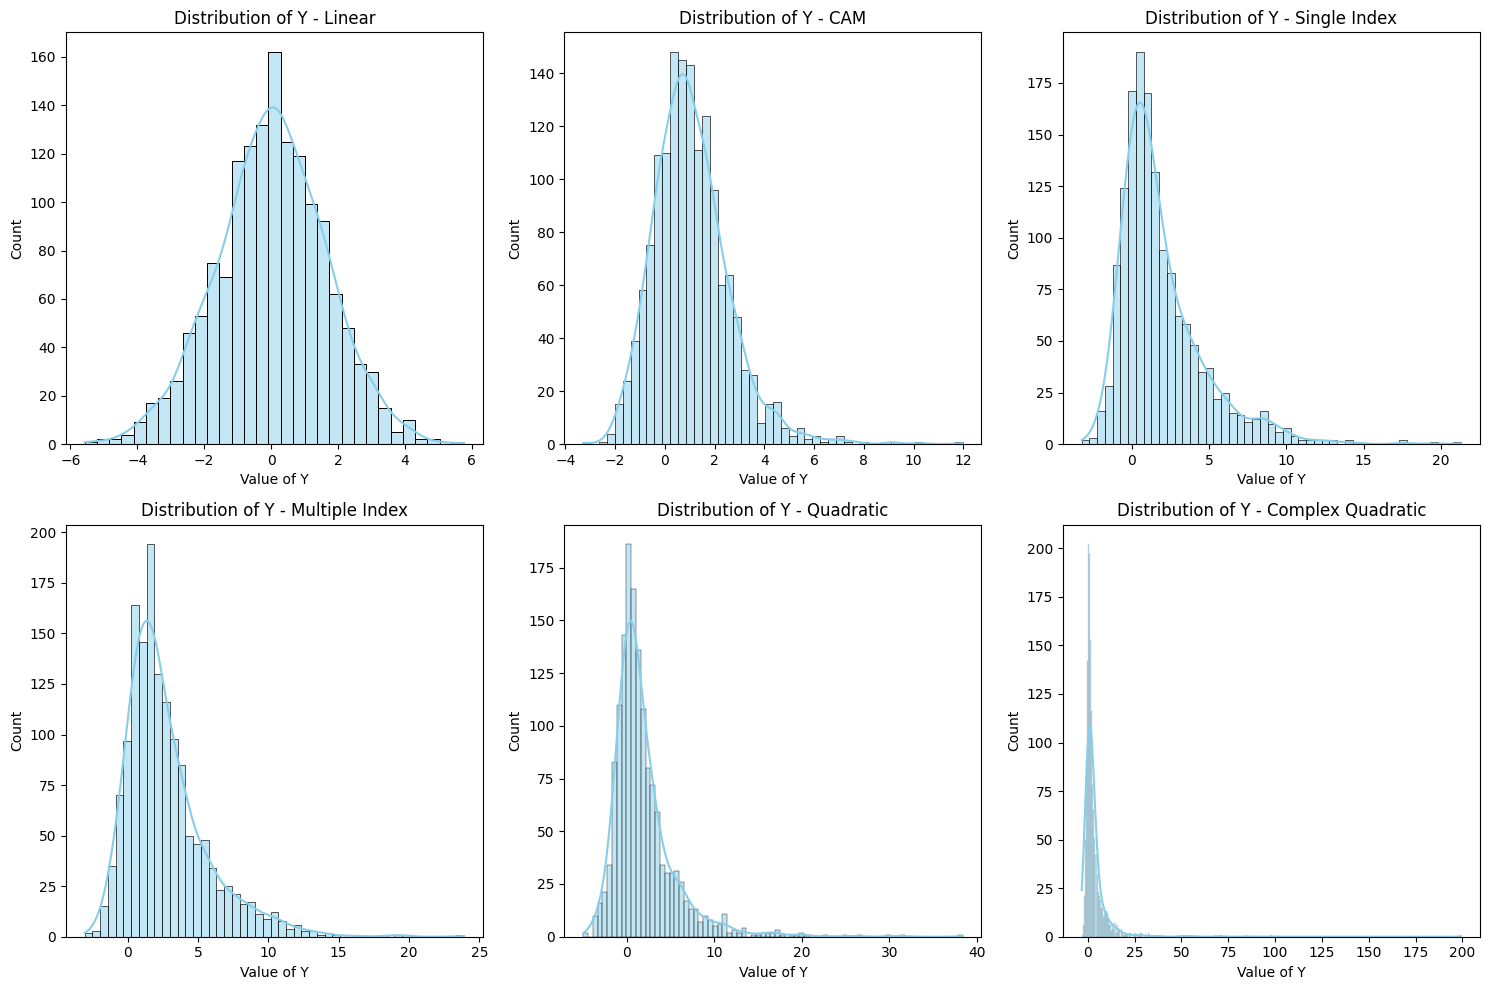

In [7]:
def plot_scenarios_distribution(X, t):
    scenarios = {
        "Linear": scenario_linear(X),
        "CAM": scenario_cam(X),
        "Single Index": scenario_single_index(X),
        "Multiple Index": scenario_multiple_index(X),
        "Quadratic": scenario_quadratic(X),
        "Complex Quadratic": scenario_complex_quadratic(X)
    }
    
    plt.figure(figsize=(15, 10))
    for i, (name, y) in enumerate(scenarios.items(), 1):
        plt.subplot(2, 3, i)
        sns.histplot(y, kde=True, color='skyblue')
        plt.title(f"Distribution of Y - {name}")
        plt.xlabel("Value of Y")
        
    plt.tight_layout()
    plt.show()

n = 1500
X = simulate_functions(n_sim, t)
plot_scenarios_distribution(X, t)


In [8]:
# implementation of model CAM

class CAM_Model(BaseEstimator, RegressorMixin):
    def __init__(self, dt):
        self.dt = dt
        self.model = LinearRegression()

    def fit(self, X, y):
        # Feature CAM : integral X(t)^2 dt
        Z = np.sum(X**2, axis=1).reshape(-1, 1) * self.dt
        self.model.fit(Z, y)
        return self

    def predict(self, X):
        Z = np.sum(X**2, axis=1).reshape(-1, 1) * self.dt
        return self.model.predict(Z)


In [9]:
# implementation of FNN 

fnn_model = Pipeline([
    ('pca', PCA(n_components=10)), # On garde les 10 principales composantes (comme souvent en FDA)
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, early_stopping=True))
])

In [11]:
# implementation of FDNN 
class FDNN_Model(nn.Module):
    def __init__(self, m, hidden_neurons=64, grid_size=50):
        super(FDNN_Model, self).__init__()
        self.m = m
        self.grid_size = grid_size
        
        # Couche fonctionnelle : m -> grid_size -> hidden_neurons
        self.w1 = nn.Parameter(torch.randn(m, grid_size))
        self.b1 = nn.Parameter(torch.randn(grid_size))
        
        self.w2 = nn.Parameter(torch.randn(grid_size, hidden_neurons))
        self.b2 = nn.Parameter(torch.randn(hidden_neurons))
        
        self.output_layer = nn.Linear(hidden_neurons, 1)
        
    def forward(self, x):
        dt = 1.0 / self.m
        
        # Première couche continue
        h1 = torch.relu((x @ self.w1) * dt + self.b1)  # (batch, grid_size)
        
        # Deuxième couche
        h2 = torch.relu((h1 @ self.w2) + self.b2)  # (batch, hidden_neurons)
        
        return self.output_layer(h2)

In [12]:
# implementation of FBNN model

def get_bspline_basis(m, n_bases=10):
    # Generate a matrix of B-spline of lenght (m, n_bases)
    knots = np.linspace(0, 1, n_bases + 4) # 4 pour l'ordre cubique
    basis_matrix = np.zeros((m, n_bases))
    t_grid = np.linspace(0, 1, m)
    for i in range(n_bases):
        coeffs = np.zeros(n_bases)
        coeffs[i] = 1
        spline = BSpline(knots, coeffs, 3)
        basis_matrix[:, i] = spline(t_grid)
    return torch.tensor(basis_matrix, dtype=torch.float32)

class FBNN_Model(nn.Module):
    def __init__(self, m, n_bases=10, hidden_neurons=64):
        super(FBNN_Model, self).__init__()
        self.basis_matrix = get_bspline_basis(m, n_bases) # (m, n_bases)
        # Only the spline coefficients are learned.
        self.basis_coeffs = nn.Parameter(torch.randn(n_bases, hidden_neurons))
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_neurons, 1)

    def forward(self, x):
        # We reconstruct beta(t) from the bases
        beta = self.basis_matrix @ self.basis_coeffs # (m, hidden_neurons)
        # Integral : X @ beta * dt
        dt = 1.0 / x.shape[1]
        out = (x @ beta) * dt
        out = self.activation(out)
        return self.output_layer(out)

In [13]:
# comparison of models 

# wrapper to make fdnn compatible with the loop
 
class TorchWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, m, lr=0.001, epochs=200, patience=10):  # lr à 0.001 et epochs à 200
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.model = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self.model = self.model_class(self.m)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

        if X_val is not None:
            X_val = torch.tensor(X_val, dtype=torch.float32)
            y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

            # Initialiser best_state
            best_val = np.inf
            patience_counter = 0
            best_state = None 

            for epoch in range(self.epochs):
                self.model.train()
                optimizer.zero_grad()
                loss = criterion(self.model(X_train), y_train)
                loss.backward()
                optimizer.step()

                self.model.eval()
                with torch.no_grad():
                    val_loss = criterion(self.model(X_val), y_val).item()

                if val_loss < best_val:
                    best_val = val_loss
                    patience_counter = 0
                    # Sauvegarder le meilleur modèle
                    best_state = {k: v.clone() for k, v in self.model.state_dict().items()}
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    # Restaurer le meilleur modèle avant d'arrêter
                    if best_state is not None:
                        self.model.load_state_dict(best_state)
                    break
        else:
            # Cas sans validation (entraînement simple)
            for epoch in range(self.epochs):
                self.model.train()
                optimizer.zero_grad()
                loss = criterion(self.model(X_train), y_train)
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            return self.model(X_t).numpy().flatten()

scenarios = {
    "Linear": scenario_linear,
    "CAM": scenario_cam,
    "Single Index": scenario_single_index,
    "Multiple Index": scenario_multiple_index,
    "Quadratic": scenario_quadratic,
    "Complex Quadratic": scenario_complex_quadratic
}

models_regression = {
    # approximation of FLM (Functional Linear Model)
    "Linear Regression": LinearRegression(),
    "CAM": CAM_Model(dt=dt),
    # classic neural network
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 100),
                                   max_iter=500,
                                   early_stopping=True),
    "FNN": fnn_model,
    # "FNN": "Modèle avec base de fonctions (ex: Fourier/B-splines)",
    "FDNN": TorchWrapper(FDNN_Model, m=200),
    "FBNN": TorchWrapper(FBNN_Model, m=200)
}

print(f"Starting {n_iterations} iterations for each scenario...")

all_results = []

for iteration in range(n_iterations):
    # Generate new X features at each iteration for variability
    X = simulate_functions(n_sim, t)
    
    for scen_name, scen_func in scenarios.items():
        # Generate the Y response for this scenario
        y = scen_func(X)
        
        # Split article
        X_train, X_test = X[:1000], X[1000:]
        y_train, y_test = y[:1000], y[1000:]

        # Split validation (deep learning)
        X_tr, X_val = X_train[:500], X_train[500:]
        y_tr, y_val = y_train[:500], y_train[500:]
        
        for model_name, model in models_regression.items():

            if "FDNN" in model_name or "FBNN" in model_name:
                # Ces modèles PyTorch utilisent leur propre early stopping
                model.fit(X_tr, y_tr, X_val=X_val, y_val=y_val)
            else:
                if "Neural Network" in model_name or "FNN" in model_name:
                    # Ces modèles scikit-learn ont early_stopping=True intégré
                    model.fit(X_train, y_train)
                else:
                    # Modèles classiques (Linear Regression, CAM)
                    model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            print(scen_name, model_name, rmse)

            all_results.append({
                "Iteration": iteration,
                "Scenario": scen_name,
                "Model": model_name,
                "RMSE": rmse
            })
    
    if (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration + 1}/{n_iterations} completed.")


Starting 100 iterations for each scenario...
Linear Linear Regression 1.182596732195995
Linear CAM 1.77080384174242
Linear Neural Network 1.076195285633133
Linear FNN 1.100698344287432
Linear FDNN 1.7430418742291052
Linear FBNN 1.2182017458045495
CAM Linear Regression 1.6519520034192583
CAM CAM 1.0091294414697312
CAM Neural Network 1.058208621406558
CAM FNN 1.0848287144324988
CAM FDNN 1.5057025927779242
CAM FBNN 1.206596890484942
Single Index Linear Regression 3.2480667815639723
Single Index CAM 2.7115578494160935
Single Index Neural Network 1.270818610826094
Single Index FNN 1.208192470996192
Single Index FDNN 2.7505400588162163
Single Index FBNN 1.8334987782228709
Multiple Index Linear Regression 3.684082692276348
Multiple Index CAM 2.808560380075494
Multiple Index Neural Network 1.3250075444617526
Multiple Index FNN 1.1183732413797804
Multiple Index FDNN 3.0379031401191496
Multiple Index FBNN 2.0161354066948527
Quadratic Linear Regression 3.5785742453894462
Quadratic CAM 2.092778678

In [13]:
results_df = pd.DataFrame(all_results, columns=["Scenario", "Model", "RMSE"])
results_df.head()

summary_rmse = (
    results_df
    .groupby(["Scenario", "Model"])["RMSE"]
    .mean()
    .reset_index()
)

table_2article = summary_rmse.pivot(
    index="Scenario",
    columns="Model",
    values="RMSE"
)

scenario_order = [
    "Linear",
    "CAM",
    "Single Index",
    "Multiple Index",
    "Quadratic",
    "Complex Quadratic"
]

table_2article = table_2article.loc[scenario_order]

model_order = [
    "Linear Regression",
    "CAM",
    "Neural Network",
    "FNN",
    "FDNN",
    "FBNN"
]

table_2article = table_2article[model_order]

table_2article.columns = ["FLM", "CAM", "NN", "FNN", "FDNN", "FBNN"]
table_2article = table_2article.round(3)
table_2article


KeyError: "None of [Index(['Linear', 'CAM', 'Single Index', 'Multiple Index', 'Quadratic',\n       'Complex Quadratic'],\n      dtype='object', name='Scenario')] are in the [index]"

NameError: name 'table_2article' is not defined

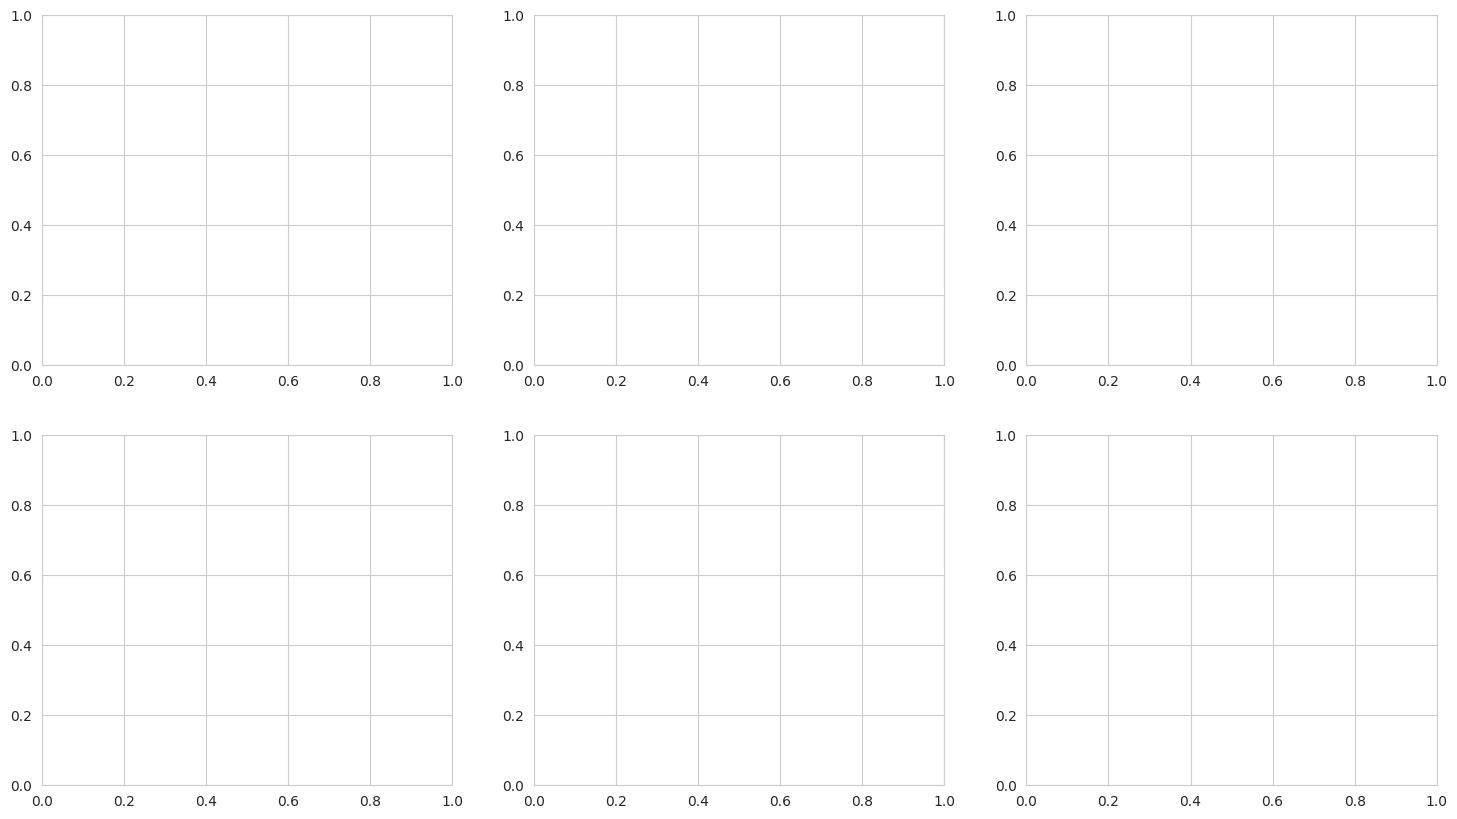

In [15]:
# Configuration du style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)


# BARPLOT PAR SCÉNARIO (6 subplots)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

scenarios = table_2article.index
colors = sns.color_palette("husl", len(table_2article.columns))

for idx, scenario in enumerate(scenarios):
    ax = axes[idx]
    
    # Données pour ce scénario
    data = table_2article.loc[scenario]
    
    # Barplot
    bars = ax.bar(data.index, data.values, color=colors, alpha=0.8, edgecolor='black')
    
    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Mise en forme
    ax.set_title(f'{scenario}', fontsize=13, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=11)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Mettre en évidence le meilleur modèle
    best_idx = data.values.argmin()
    bars[best_idx].set_edgecolor('green')
    bars[best_idx].set_linewidth(3)

plt.suptitle('RMSE Comparison by Scenario', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('rmse_by_scenario.png', dpi=300, bbox_inches='tight')
plt.show()

################################################################
# Barplot groupé 

fig, ax = plt.subplots(figsize=(16, 8))

# Préparer les données pour le barplot
table_plot = table_2article.reset_index()
table_melted = table_plot.melt(
    id_vars='Scenario', 
    var_name='Model', 
    value_name='RMSE'
)

# Créer le barplot groupé
sns.barplot(
    data=table_melted,
    x='Scenario',
    y='RMSE',
    hue='Model',
    palette='Set2',
    ax=ax
)

# Personnalisation
ax.set_title('Comparison of RMSE across Scenarios and Models', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Scenario', fontsize=13, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=13, fontweight='bold')
ax.legend(title='Model', title_fontsize=12, fontsize=11, 
          bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45, labelsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rmse_comparison_barplot.png', dpi=300, bbox_inches='tight')
plt.show()



##### y is a binary response

In [91]:
# Scenarios of true relation between Y ansd Xi(t) with binary response and a single predictor function.

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_binary_y(eta):
    # Transformation en probabilité puis tirage de Bernoulli (0 ou 1)
    p = sigmoid(eta)
    return np.random.binomial(1, p)

# Binary Scenarios

def scenario_logistic_binary(X):
    beta = 5 * np.sin(2 * np.pi * t)
    eta = (X @ beta) * dt
    return generate_binary_y(eta)

def scenario_cam_binary(X):
    # f(Xi,t) = sin(Xi(t))
    eta = np.sum(np.sin(X), axis=1) * dt
    return generate_binary_y(eta)

def scenario_single_index_binary(X):
    beta = 5 * np.sin(2 * np.pi * t)
    a = (X @ beta) * dt
    eta = np.sin(a)
    return generate_binary_y(eta)

def scenario_multiple_index_binary(X):
    beta1 = 5 * np.sin(2 * np.pi * t)
    beta2 = 5 * np.sin(3 * np.pi * t)
    a = (X @ beta1) * dt
    b = (X @ beta2) * dt
    eta = np.sin(np.sin(a) + b)
    return generate_binary_y(eta)

def scenario_quadratic_binary(X):
    beta1 = 5 * np.sin(3 * np.pi * t)
    beta2 = 5 * np.sin(np.pi * t)
    lin = (X @ beta1) * dt
    # Interaction : integral(beta1*X) * integral(beta2*X)
    quad = ((X @ beta1) * dt) * ((X @ beta2) * dt)
    eta = lin + quad
    return generate_binary_y(eta)

def scenario_complex_quadratic_binary(X):
    # f1 = integral(sin(X(t)) dt)
    term1 = np.sum(np.sin(X), axis=1) * dt
    # f2 = integral_double(sin(X(t)*X(s)) ds dt)
    # Note: For the binary complex, the double integral is more cumbersome.  
    # It can be approximated by a sum if m is not too large.
    # To remain efficient: 
    integral_sin_x = np.sum(np.sin(X), axis=1) * dt
    term2 = integral_sin_x**2 # Approche de la structure d'interaction
    eta = term1 + term2
    return generate_binary_y(eta)

In [92]:
# implementation of 6 methods 

scenarios = {
    "Logistic": scenario_logistic_binary,
    "CAM": scenario_cam_binary,
    "Single Index": scenario_single_index_binary,
    "Multiple Index": scenario_multiple_index_binary,
    "Quadratic": scenario_quadratic_binary,
    "Complex Quadratic": scenario_complex_quadratic_binary
}


# CAM Classifier 
class CAMClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        Z = np.sum(np.sin(X), axis=1).reshape(-1, 1) * dt
        self.model = LogisticRegression(max_iter=1000)
        self.model.fit(Z, y)
        return self

    def predict(self, X):
        Z = np.sum(np.sin(X), axis=1).reshape(-1, 1) * dt
        return self.model.predict(Z)
    
    def predict_proba(self, X):
        Z = np.sum(np.sin(X), axis=1).reshape(-1, 1) * dt
        return self.model.predict_proba(Z)
    

# FDNN / FBNN (binary)

def get_bspline_basis(m, n_bases=10):
    knots = np.linspace(0, 1, n_bases + 4)
    t_grid = np.linspace(0, 1, m)
    basis = np.zeros((m, n_bases))
    for i in range(n_bases):
        c = np.zeros(n_bases)
        c[i] = 1
        basis[:, i] = BSpline(knots, c, 3)(t_grid)
    return torch.tensor(basis, dtype=torch.float32)

class FDNN_Binary(nn.Module):
    def __init__(self, m, hidden_neurons=64):
        super().__init__()
        self.functional_layer = nn.Linear(m, hidden_neurons)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_neurons, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        dt = 1.0 / x.shape[1]
        out = self.functional_layer(x) * dt
        out = self.activation(out)
        out = self.output_layer(out)
        return self.sigmoid(out)
    
class FBNN_Binary(nn.Module):
    def __init__(self, m, n_bases=10, hidden_neurons=64):
        super().__init__()
        self.basis_matrix = get_bspline_basis(m, n_bases)
        self.basis_coeffs = nn.Parameter(torch.randn(n_bases, hidden_neurons))
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_neurons, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        beta = self.basis_matrix @ self.basis_coeffs
        dt = 1.0 / x.shape[1]
        out = (x @ beta) * dt
        out = self.activation(out)
        out = self.output_layer(out)
        return self.sigmoid(out)
    

class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, m, lr=0.001, epochs=200, patience=10):
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.model = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self.model = self.model_class(self.m)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.BCELoss()

        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

        if X_val is not None:
            X_val = torch.tensor(X_val, dtype=torch.float32)
            y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

            best_val = np.inf
            patience_counter = 0
            best_state = None

            for epoch in range(self.epochs):
                self.model.train()
                opt.zero_grad()
                loss = loss_fn(self.model(X_train), y_train)
                loss.backward()
                opt.step()

                self.model.eval()
                with torch.no_grad():
                    val_loss = loss_fn(self.model(X_val), y_val).item()

                if val_loss < best_val:
                    best_val = val_loss
                    patience_counter = 0
                    best_state = {k: v.clone() for k, v in self.model.state_dict().items()}
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    if best_state is not None:
                        self.model.load_state_dict(best_state)
                    break
        else:
            for epoch in range(self.epochs):
                self.model.train()
                opt.zero_grad()
                loss = loss_fn(self.model(X_train), y_train)
                loss.backward()
                opt.step()

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            p = self.model(X_t).numpy().flatten()
            return (p > 0.5).astype(int)


    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            p = self.model(X_t).numpy().flatten()
            return np.column_stack([1-p, p])




In [93]:
# wrapper with binary classification 


class TorchWrapperBinary(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, m, lr=0.001, epochs=200, patience=10):
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.patience = patience

    def fit(self, X_tr, y_tr, X_val, y_val):
        self.model = self.model_class(self.m)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.BCELoss()

        X_tr = torch.tensor(X_tr, dtype=torch.float32)
        y_tr = torch.tensor(y_tr, dtype=torch.float32).reshape(-1, 1)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

        best_loss = np.inf
        counter = 0

        for _ in range(self.epochs):
            opt.zero_grad()
            loss = loss_fn(self.model(X_tr), y_tr)
            loss.backward()
            opt.step()

            with torch.no_grad():
                val_loss = loss_fn(self.model(X_val), y_val)

            if val_loss < best_loss:
                best_loss = val_loss
                best_state = deepcopy(self.model.state_dict())
                counter = 0
            else:
                counter += 1
                if counter >= self.patience:
                    break

        self.model.load_state_dict(best_state)
        return self

    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32)
            return (self.model(X).numpy().flatten() > 0.5).astype(int)


In [ ]:
# models 

models_classification = {
    "FLM": lambda: LogisticRegression(max_iter=1000),
    "CAM": lambda: CAMClassifier(),
    "NN": lambda: MLPClassifier(hidden_layer_sizes=(100,100), max_iter=500),
    "FNN": lambda: Pipeline([
        ('pca', PCA(n_components=10)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100,100), max_iter=500))
    ]),
    "FDNN": lambda: TorchClassifier(FDNN_Binary, m=200),
    "FBNN": lambda: TorchClassifier(FBNN_Binary, m=200)
}


# Simulation loop
results = []

for iteration in range(100):
    X = simulate_functions(n, t)

    for scen_name, scen_fun in scenarios.items():
        y = scen_fun(X)

        X_train, X_test = X[:1000], X[1000:]
        y_train, y_test = y[:1000], y[1000:]
        
        X_tr, X_val = X_train[:700], X_train[700:]
        y_tr, y_val = y_train[:700], y_train[700:]

        for name, make_model in models_classification.items():
            model = make_model()
            
            if "FDNN" in name or "FBNN" in name:
                model.fit(X_tr, y_tr, X_val=X_val, y_val=y_val)
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            err = 1 - accuracy_score(y_test, y_pred)
            
            # Log-likelihood
            if hasattr(model, 'predict_proba'):
                y_proba = model.predict_proba(X_test)
                ll = -log_loss(y_test, y_proba)
            else:
                # Modèles PyTorch (FDNN, FBNN)
                if "FDNN" in name or "FBNN" in name:
                    with torch.no_grad():
                        X_t = torch.tensor(X_test, dtype=torch.float32)
                        y_proba = model.model(X_t).numpy().flatten()
                    # log_loss attend shape (n_samples, 2) pour binaire
                    y_proba_2d = np.column_stack([1 - y_proba, y_proba])
                    ll = -log_loss(y_test, y_proba_2d)
                else:
                    ll = np.nan

            results.append([scen_name, name, err, ll])
    
    if (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration + 1}/100 completed.")

# Résultats
df = pd.DataFrame(results, columns=["Scenario", "Model", "Error", "LogLikelihood"])

# Table 4 (Classification Error)
table4 = df.groupby(["Scenario", "Model"])["Error"].mean().unstack()
print("\n=== TABLE 4: Classification Error ===")
print(table4.round(3))

# Table Log-Likelihood
table_ll = df.groupby(["Scenario", "Model"])["LogLikelihood"].mean().unstack()
print("\n=== Log-Likelihood ===")
print(table_ll.round(3))



/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.1

### Real Data 

LOADING DATASETS

 Loading Tecator dataset...
✓ Tecator: 215 samples, 100 wavelength points
  X shape: (215, 100)
  y shape: (215,)
  Fat content range: [0.90, 49.10]
  Fat content mean: 18.14 ± 12.71

Loading Growth dataset...
✓ Growth: 93 samples, 31 time points
  Classes: [0 1] (0=Boys, 1=Girls)
  Class distribution: Boys=39, Girls=54

 Loading Phonemes dataset...
✓ Phonemes: 1717 samples, 150 frequency points
  Classes: ['aa' 'ao'] → [0 1]
  Class distribution: aa=695, ao=1022

 Generating visualizations...


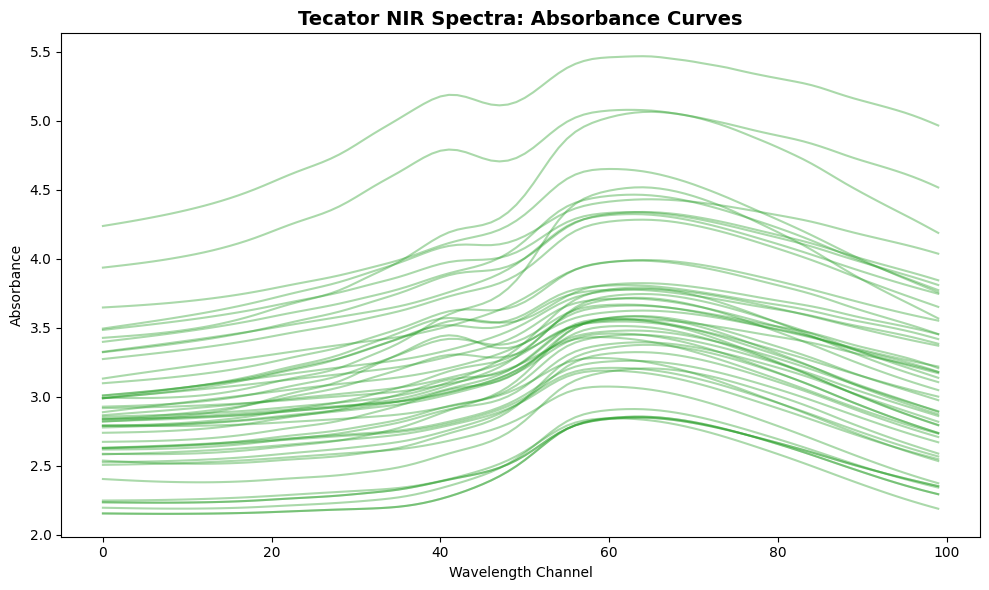

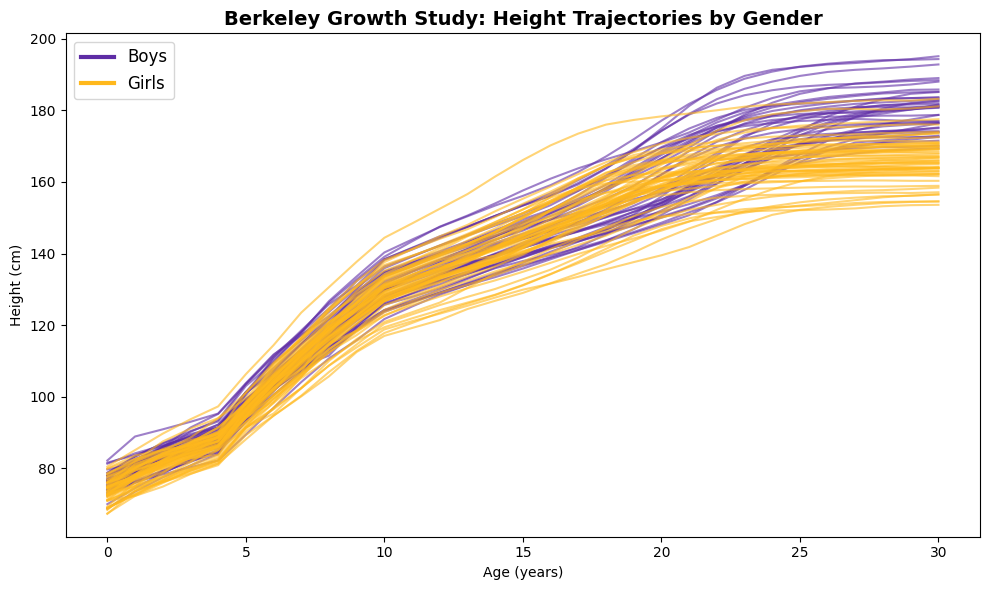

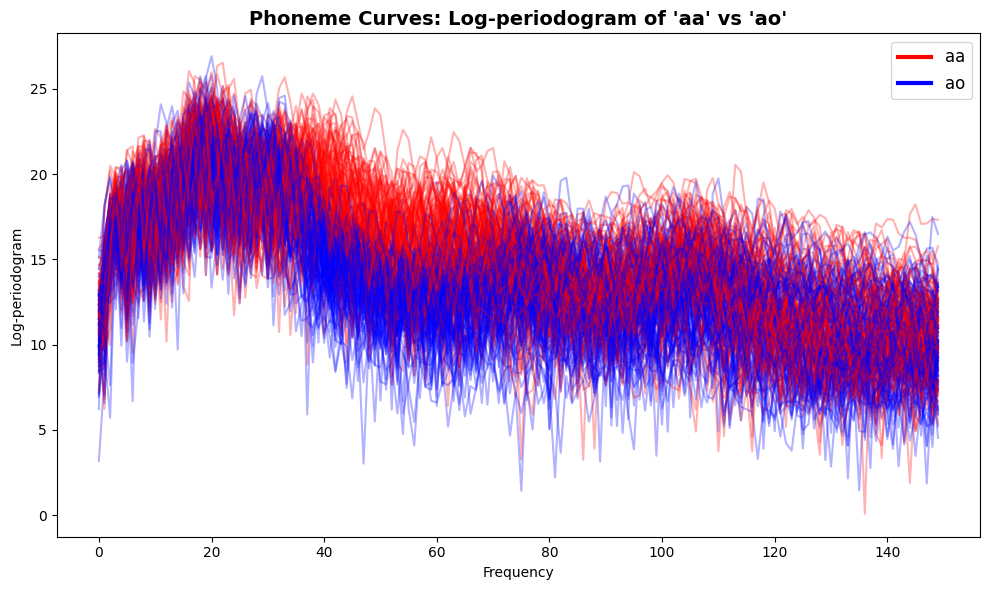


STARTING EVALUATION ON REAL DATASETS

EVALUATING: Fat Spectrum (REGRESSION)
Total samples available: 215
Split → Train: 137, Val: 35, Test: 43
Features: 100

  Training FLM... ✓ RMSE: 6.426

  Training CAM... ✓ RMSE: 12.624

  Training NN... ✓ RMSE: 12.389

  Training FNN... ✓ RMSE: 2.796

  Training FDNN... 

/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/torch/autograd/graph.py:841: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


✓ RMSE: 12.367

  Training FBNN... ✓ RMSE: 21.496

EVALUATING: Growth (CLASSIFICATION)
Total samples available: 93
Split → Train: 59, Val: 15, Test: 19
Features: 31

  Training FLM... ✓ Error: 0.105 (Accuracy: 0.895)

  Training CAM... ✓ Error: 0.421 (Accuracy: 0.579)

  Training NN... ✓ Error: 0.579 (Accuracy: 0.421)

  Training FNN... ✓ Error: 0.105 (Accuracy: 0.895)

  Training FDNN... ✓ Error: 0.789 (Accuracy: 0.211)

  Training FBNN... ✓ Error: 0.579 (Accuracy: 0.421)

EVALUATING: Phonemes (CLASSIFICATION)
Total samples available: 1717
Split → Train: 1098, Val: 275, Test: 344
Features: 150

  Training FLM... ✓ Error: 0.221 (Accuracy: 0.779)

  Training CAM... ✓ Error: 0.404 (Accuracy: 0.596)

  Training NN... ✓ Error: 0.224 (Accuracy: 0.776)

  Training FNN... ✓ Error: 0.198 (Accuracy: 0.802)

  Training FDNN... ✓ Error: 0.195 (Accuracy: 0.805)

  Training FBNN... ✓ Error: 0.404 (Accuracy: 0.596)

TABLE 5 – REAL DATA RESULTS

                FLM     CAM      NN    FNN    FDNN    F

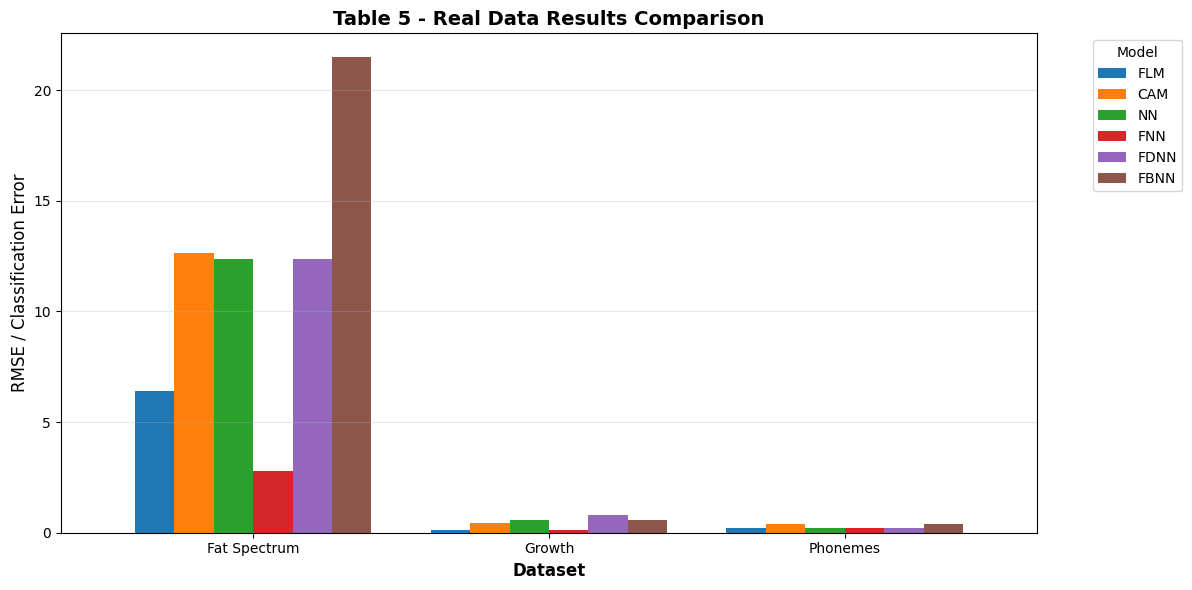

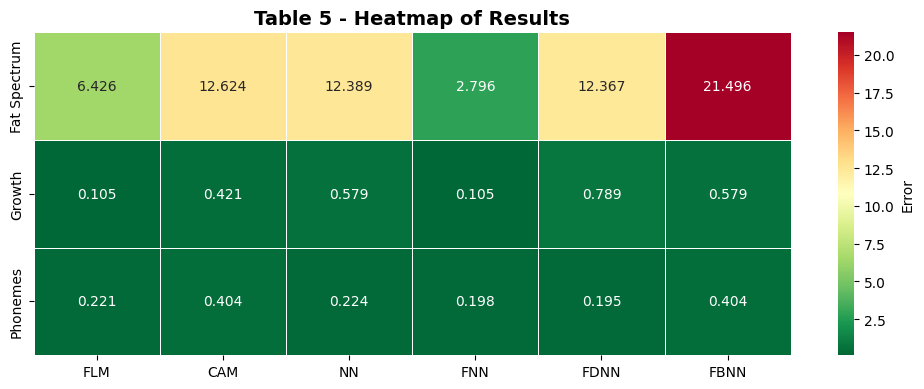


 ALL DONE! Check the generated plots and CSV file.


In [ ]:
# Loading and data visualization

print("="*70)
print("LOADING DATASETS")
print("="*70)

print("\n Loading Tecator dataset...")
tecator = fetch_tecator()
X_tecator_raw = tecator.data.data_matrix.squeeze()

# Extraire seulement la colonne 'fat' (colonne 0)
y_tecator = tecator.target[:, 0]  # Prendre uniquement la première colonne

print(f"✓ Tecator: {X_tecator_raw.shape[0]} samples, {X_tecator_raw.shape[1]} wavelength points")
print(f"  X shape: {X_tecator_raw.shape}")
print(f"  y shape: {y_tecator.shape}")
print(f"  Fat content range: [{y_tecator.min():.2f}, {y_tecator.max():.2f}]")
print(f"  Fat content mean: {y_tecator.mean():.2f} ± {y_tecator.std():.2f}")

# Vérification
assert X_tecator_raw.shape[0] == y_tecator.shape[0], \
    f"Mismatch: X has {X_tecator_raw.shape[0]} samples but y has {y_tecator.shape[0]}"


# Berkeley Growth Study (Classification: Boys vs Girls)
print("\nLoading Growth dataset...")
growth = fetch_growth()
X_growth_raw = growth.data.data_matrix.squeeze()
y_growth = growth.target
print(f"✓ Growth: {X_growth_raw.shape[0]} samples, {X_growth_raw.shape[1]} time points")
print(f"  Classes: {np.unique(y_growth)} (0=Boys, 1=Girls)")
print(f"  Class distribution: Boys={np.sum(y_growth==0)}, Girls={np.sum(y_growth==1)}")

# Phonemes data (Classification: aa vs ao)
print("\n Loading Phonemes dataset...")
phoneme = pd.read_csv('phonemes.csv', index_col=0)
subset_phonemes = phoneme[phoneme['g'].isin(['aa', 'ao'])].copy()
X_phonemes = subset_phonemes.iloc[:, 0:150].values
y_phonemes_labels = subset_phonemes['g'].values

# Encoder les labels en 0/1
le = LabelEncoder()
y_phonemes = le.fit_transform(y_phonemes_labels)
print(f"✓ Phonemes: {X_phonemes.shape[0]} samples, {X_phonemes.shape[1]} frequency points")
print(f"  Classes: {le.classes_} → {np.unique(y_phonemes)}")
print(f"  Class distribution: {le.classes_[0]}={np.sum(y_phonemes==0)}, {le.classes_[1]}={np.sum(y_phonemes==1)}")


# Visualization

print("\n Generating visualizations...")

# Tecator
plt.figure(figsize=(10, 6))
for i in range(min(50, len(X_tecator_raw))):
    plt.plot(X_tecator_raw[i], alpha=0.4, color='tab:green')
plt.title("Tecator NIR Spectra: Absorbance Curves", fontsize=14, fontweight='bold')
plt.xlabel("Wavelength Channel")
plt.ylabel("Absorbance")
plt.tight_layout()
plt.savefig('tecator_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Growth
color_boys = '#5E2CA5'
color_girls = '#FFB81C'
plt.figure(figsize=(10, 6))
for i in range(len(X_growth_raw)):
    color = color_boys if y_growth[i] == 0 else color_girls
    plt.plot(X_growth_raw[i], color=color, alpha=0.6, linewidth=1.5)
plt.title("Berkeley Growth Study: Height Trajectories by Gender", fontsize=14, fontweight='bold')
plt.xlabel("Age (years)")
plt.ylabel("Height (cm)")
custom_lines = [Line2D([0], [0], color=color_boys, lw=3),
                Line2D([0], [0], color=color_girls, lw=3)]
plt.legend(custom_lines, ['Boys', 'Girls'], loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('growth_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Phonemes
plt.figure(figsize=(10, 6))
for i in range(min(200, len(X_phonemes))):
    color = 'red' if y_phonemes[i] == 0 else 'blue'
    plt.plot(X_phonemes[i], color=color, alpha=0.3)
plt.title(f"Phoneme Curves: Log-periodogram of '{le.classes_[0]}' vs '{le.classes_[1]}'", 
          fontsize=14, fontweight='bold')
plt.xlabel("Frequency")
plt.ylabel("Log-periodogram")
custom_legend = [Line2D([0], [0], color='red', lw=3),
                 Line2D([0], [0], color='blue', lw=3)]
plt.legend(custom_legend, [le.classes_[0], le.classes_[1]], fontsize=12)
plt.tight_layout()
plt.savefig('phonemes_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Models - cam

class CAM_Regression(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = LinearRegression()
    
    def fit(self, X, y):
        # Feature: sum(X^2) (intégrale de X²)
        Z = np.sum(X**2, axis=1).reshape(-1, 1)
        self.model.fit(Z, y)
        return self
    
    def predict(self, X):
        Z = np.sum(X**2, axis=1).reshape(-1, 1)
        return self.model.predict(Z)

class CAM_Classification(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = LogisticRegression(max_iter=1000)
    
    def fit(self, X, y):
        # Feature: sum(sin(X))
        Z = np.sum(np.sin(X), axis=1).reshape(-1, 1)
        self.model.fit(Z, y)
        return self
    
    def predict(self, X):
        Z = np.sum(np.sin(X), axis=1).reshape(-1, 1)
        return self.model.predict(Z)


# Models PyTorch (FBNN, FDNN)

def get_bspline_basis(m, n_bases=10):
    knots = np.linspace(0, 1, n_bases + 4)
    t_grid = np.linspace(0, 1, m)
    basis = np.zeros((m, n_bases))
    for i in range(n_bases):
        c = np.zeros(n_bases)
        c[i] = 1
        basis[:, i] = BSpline(knots, c, 3)(t_grid)
    return torch.tensor(basis, dtype=torch.float32)

# FDNN - Regression
class FDNN_Reg(nn.Module):
    def __init__(self, m, hidden=64):
        super().__init__()
        self.fc1 = nn.Linear(m, hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# FDNN - Classification
class FDNN_Clf(nn.Module):
    def __init__(self, m, hidden=64):
        super().__init__()
        self.fc1 = nn.Linear(m, hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.sigmoid(self.fc2(x))

# FBNN - Regression
class FBNN_Reg(nn.Module):
    def __init__(self, m, n_bases=10, hidden=64):
        super().__init__()
        self.basis = get_bspline_basis(m, n_bases)
        self.coeffs = nn.Parameter(torch.randn(n_bases, hidden))
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden, 1)
    
    def forward(self, x):
        beta = self.basis @ self.coeffs
        x = self.relu(x @ beta)
        return self.fc(x)

# FBNN - Classification
class FBNN_Clf(nn.Module):
    def __init__(self, m, n_bases=10, hidden=64):
        super().__init__()
        self.basis = get_bspline_basis(m, n_bases)
        self.coeffs = nn.Parameter(torch.randn(n_bases, hidden))
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        beta = self.basis @ self.coeffs
        x = self.relu(x @ beta)
        return self.sigmoid(self.fc(x))

# Wrapper PyTorch - Regression
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, m, lr=0.001, epochs=200, patience=10):
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.model = None
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self.model = self.model_class(self.m)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        
        if X_val is not None:
            X_val = torch.tensor(X_val, dtype=torch.float32)
            y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
            
            best_loss = np.inf
            counter = 0
            best_state = None
            
            for epoch in range(self.epochs):
                self.model.train()
                opt.zero_grad()
                loss = criterion(self.model(X_train), y_train)
                loss.backward()
                opt.step()
                
                self.model.eval()
                with torch.no_grad():
                    val_loss = criterion(self.model(X_val), y_val).item()
                
                if val_loss < best_loss:
                    best_loss = val_loss
                    counter = 0
                    best_state = {k: v.clone() for k, v in self.model.state_dict().items()}
                else:
                    counter += 1
                    if counter >= self.patience:
                        break
            
            if best_state is not None:
                self.model.load_state_dict(best_state)
        else:
            for epoch in range(self.epochs):
                self.model.train()
                opt.zero_grad()
                loss = criterion(self.model(X_train), y_train)
                loss.backward()
                opt.step()
        
        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32)
            return self.model(X).numpy().flatten()

# Wrapper PyTorch - Classification
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, m, lr=0.001, epochs=200, patience=10):
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.model = None
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self.model = self.model_class(self.m)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.BCELoss()
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        
        if X_val is not None:
            X_val = torch.tensor(X_val, dtype=torch.float32)
            y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
            
            best_loss = np.inf
            counter = 0
            best_state = None
            
            for epoch in range(self.epochs):
                self.model.train()
                opt.zero_grad()
                loss = criterion(self.model(X_train), y_train)
                loss.backward()
                opt.step()
                
                self.model.eval()
                with torch.no_grad():
                    val_loss = criterion(self.model(X_val), y_val).item()
                
                if val_loss < best_loss:
                    best_loss = val_loss
                    counter = 0
                    best_state = {k: v.clone() for k, v in self.model.state_dict().items()}
                else:
                    counter += 1
                    if counter >= self.patience:
                        break
            
            if best_state is not None:
                self.model.load_state_dict(best_state)
        else:
            for epoch in range(self.epochs):
                self.model.train()
                opt.zero_grad()
                loss = criterion(self.model(X_train), y_train)
                loss.backward()
                opt.step()
        
        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32)
            return (self.model(X).numpy().flatten() > 0.5).astype(int)


# Evaluation

def evaluate_dataset(X, y, task, dataset_name):
    """
    Evaluate all models on a dataset 
    
    Args:
        X: Features (n_samples, n_features)
        y: Target
        task: 'regression' ou 'classification'
        dataset_name: Nom du dataset pour affichage
    """
    print(f"\n{'='*70}")
    print(f"EVALUATING: {dataset_name} ({task.upper()})")
    print(f"{'='*70}")
    
    n_samples = len(X)
    print(f"Total samples available: {n_samples}")
    
    # Split adapté aux données réelles disponibles
    if dataset_name == "Fat Spectrum":
        # Tecator: utiliser environ 80% train (dont 20% val), 20% test
        # Article: 176+40=216 train, 40 test, mais on a 215
        # On adapte: 172 train (dont 43 val) + 43 test = 215
        test_size = 0.2
        val_ratio = 0.2  # 20% du train pour validation
        
    elif dataset_name == "Growth":
        # Growth: environ 78% train (dont 21% val), 22% test
        # Article: 73+20=93 train, 20 test
        test_size = 0.2
        val_ratio = 0.2
        
    else:  # Phonemes
        # Phonemes: 80% train (dont 20% val), 20% test
        # Article: 640+160=800 train, 160 test
        test_size = 0.2
        val_ratio = 0.2
    
    # Split train/test
    from sklearn.model_selection import train_test_split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y if task=='classification' else None
    )
    
    # Split train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_ratio, random_state=42,
        stratify=y_train_full if task=='classification' else None
    )
    
    m = X.shape[1]  # Nombre de features
    
    print(f"Split → Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    print(f"Features: {m}")
    
    # Définir les modèles
    if task == 'regression':
        models = {
            "FLM": LinearRegression(),
            "CAM": CAM_Regression(),
            "NN": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, 
                              early_stopping=True, random_state=42),
            "FNN": Pipeline([
                ('pca', PCA(n_components=10)),
                ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500,
                                    early_stopping=True, random_state=42))
            ]),
            "FDNN": TorchRegressor(FDNN_Reg, m, lr=0.001, epochs=200, patience=10),
            "FBNN": TorchRegressor(FBNN_Reg, m, lr=0.001, epochs=200, patience=10)
        }
    else:  # classification
        models = {
            "FLM": LogisticRegression(max_iter=1000, random_state=42),
            "CAM": CAM_Classification(),
            "NN": MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500,
                               random_state=42),
            "FNN": Pipeline([
                ('pca', PCA(n_components=10)),
                ('mlp', MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500,
                                     random_state=42))
            ]),
            "FDNN": TorchClassifier(FDNN_Clf, m, lr=0.001, epochs=200, patience=10),
            "FBNN": TorchClassifier(FBNN_Clf, m, lr=0.001, epochs=200, patience=10)
        }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n  Training {name}...", end=" ")
        
        try:
            # Entraînement
            if name in ["FDNN", "FBNN"]:
                model.fit(X_train, y_train, X_val=X_val, y_val=y_val)
            else:
                model.fit(X_train_full, y_train_full)
            
            # Prédiction
            y_pred = model.predict(X_test)
            
            # Évaluation
            if task == 'regression':
                score = np.sqrt(mean_squared_error(y_test, y_pred))
                print(f"✓ RMSE: {score:.3f}")
            else:
                score = 1 - accuracy_score(y_test, y_pred)
                acc = accuracy_score(y_test, y_pred)
                print(f"✓ Error: {score:.3f} (Accuracy: {acc:.3f})")
            
            results[name] = score
            
        except Exception as e:
            print(f" FAILED: {str(e)[:50]}")
            results[name] = np.nan
    
    return results

#Evaluation on the 3 datasets 


print("\n" + "="*70)
print("STARTING EVALUATION ON REAL DATASETS")
print("="*70)

all_results = {}

# Tecator (Regression)
all_results["Fat Spectrum"] = evaluate_dataset(
    X_tecator_raw, y_tecator, 'regression', "Fat Spectrum"
)

# Growth (Classification)
all_results["Growth"] = evaluate_dataset(
    X_growth_raw, y_growth, 'classification', "Growth"
)

# Phonemes (Classification)
all_results["Phonemes"] = evaluate_dataset(
    X_phonemes, y_phonemes, 'classification', "Phonemes"
)


# Final results


print("\n" + "="*70)
print("TABLE 5 – REAL DATA RESULTS")
print("="*70)

table5 = pd.DataFrame(all_results).T
table5 = table5[["FLM", "CAM", "NN", "FNN", "FDNN", "FBNN"]]
print("\n" + table5.round(3).to_string())

# Sauvegarder
table5.round(3).to_csv('table5_real_data_results.csv')
print("\n✓ Results saved to 'table5_real_data_results.csv'")


# Results visualisations 

print("\n Generating comparison plots...")

# Barplot
fig, ax = plt.subplots(figsize=(12, 6))
table5.plot(kind='bar', ax=ax, rot=0, width=0.8)
ax.set_title('Table 5 - Real Data Results Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE / Classification Error', fontsize=12)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('table5_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(table5, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'Error'}, ax=ax)
ax.set_title('Table 5 - Heatmap of Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('table5_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n ALL DONE! Check the generated plots and CSV file.")